(data-extraction)=
# Getting Data


## Introduction

In this chapter, you'll learn about some different ways to extract or obtain data: from the web, from documents, and elsewhere. This chapter uses packages such as **pandas-datareader** and **BeautifulSoup** that you may need to install first.

### Imports

First we need to import the packages we'll be using

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
import textwrap

In [2]:
import matplotlib_inline.backend_inline

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

# Set max rows displayed for readability
pd.set_option("display.max_rows", 6)

## Extracting data from files on the internet

As you will have seen in some of the examples in this book, it's easy to read data from the internet once you have the url and file type. Here, for instance, is an example that reads in the 'storms' dataset (we'll only grab the first 10 rows):

In [3]:
pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/dplyr/storms.csv", nrows=10
)

,rownames,name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
0,1,Amy,1975,6,27,0,27.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
1,2,Amy,1975,6,27,6,28.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
2,3,Amy,1975,6,27,12,29.5,-79.0,tropical depression,NaN,25,1013,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,8,Amy,1975,6,28,18,34.0,-77.0,tropical depression,NaN,30,1006,NaN,NaN
8,9,Amy,1975,6,29,0,34.4,-75.8,tropical storm,NaN,35,1004,NaN,NaN
9,10,Amy,1975,6,29,6,34.0,-74.8,tropical storm,NaN,40,1002,NaN,NaN


## Obtaining data using APIs

Using an API (application programming interface) is another way to draw down information from the interweb. Their just a way for one tool, say Python, to speak to another tool, say a server, and usefully exchange information. The classic use case would be to post a request for data that fits a certain query via an API and to get a download of that data back in return. (You should always preferentially use an API over webscraping a site—you can read more about [why APIs are so great here](https://aeturrell.com/blog/posts/the-prize-with-apis/the-prize-with-apis.html).)

Because they are designed to work with any tool, you don't actually need a programming language to interact with an API, it's just a *lot* easier if you do.

```{note}
An API key is needed in order to access some APIs. Sometimes all you need to do is register with site, in other cases you may have to pay for access.
```

To see this, let's directly use an API to get some time series data. We will make the call out to the internet using the **requests** package.

An API has an 'endpoint', the base url, and then a URL that encodes the question. Let's see an example with the ONS API for which the endpoint is "https://api.ons.gov.uk/". The rest of the API has the form 'key/value', for example we'll ask for timeseries data 'timeseries' followed by 'JP9Z' for the vacancies in the UK services sector. We then ask for 'dataset' followed by 'UNEM' to specify which overarching dataset the series we want is in. The last part asks for the data with 'data'. Often you won't need to know all of these details, but it's useful to see a detailed example.

The data that are returned by APIs are typically in JSON format, which looks a lot like a nested Python dictionary and its entries can be accessed in the same way--this is what is happening when getting the series' title in the example below. JSON is not good for analysis, so we'll use **pandas** to put the data into shape.

In [6]:
import requests

url = "https://api.ons.gov.uk/timeseries/JP9Z/dataset/UNEM/data"

# Get the data from the ONS API:
json_data = requests.get(url).json()

# Prep the data for a quick plot
title = json_data["description"]["title"]
df = (
    pd.DataFrame(pd.json_normalize(json_data["months"]))
    .assign(
        date=lambda x: pd.to_datetime(x["date"]),
        value=lambda x: pd.to_numeric(x["value"]),
    )
    .set_index("date")
)

df["value"].plot(title=title, ylim=(0, df["value"].max() * 1.2), lw=3.0)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

We've talked about *reading* APIs. You can also create your own to serve up data, models, whatever you like! This is an advanced topic and we won't cover it; but if you do need to, the simplest way is to use [Fast API](https://fastapi.tiangolo.com/). You can find some short video tutorials for Fast API [here](https://calmcode.io/fastapi/hello-world.html).

### Pandas Datareader: an easier way to interact with (some) APIs

Although it didn't take much code to get the ONS data, it would be even better if it was just a single line, wouldn't it? Fortunately there are some packages out there that make this easy, but it does depend on the API (and APIs come and go over time).

By far the most comprehensive library for accessing extra APIs is [**pandas-datareader**](https://pandas-datareader.readthedocs.io/en/latest/), which provides convenient access to:

- FRED
- Quandl
- World Bank
- OECD
- Eurostat

and more.

Let's see an example using FRED (the Federal Reserve Bank of St. Louis' economic data library). This time, let's look at the UK unemployment rate:

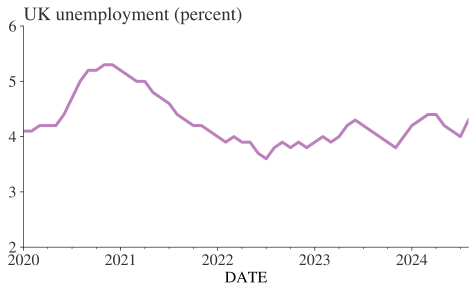

In [8]:
import pandas_datareader.data as web

df_u = web.DataReader("LRHUTTTTGBM156S", "fred")

df_u.plot(title="UK unemployment (percent)", legend=False, ylim=(2, 6), lw=3.0);

And, because it's also a really useful one, let's also see how to use **pandas-datareader** to access World Bank data.

In [9]:
# World Bank CO2 emissions (metric tons per capita)
# https://data.worldbank.org/indicator/EN.ATM.CO2E.PC
# World Bank pop
# https://data.worldbank.org/indicator/SP.POP.TOTL
# country and region codes at http://api.worldbank.org/v2/country
from pandas_datareader import wb
df = wb.download(
    indicator="EN.ATM.CO2E.PC",
    country=["US", "CHN", "IND", "Z4", "Z7"],
    start=2017,
    end=2017,
)
# remove country as index for ease of plotting with seaborn
df = df.reset_index()
# wrap long country names
df["country"] = df["country"].apply(lambda x: textwrap.fill(x, 10))
# order based on size
df = df.sort_values("EN.ATM.CO2E.PC")
df.head()

/Users/apple/Documents/GitHub/YunlongWei_Homework/.venv/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: Z4, Z7
  warnings.warn(
/Users/apple/Documents/GitHub/YunlongWei_Homework/.venv/lib/python3.10/site-packages/pandas_datareader/wb.py:659: UserWarning: Problem with a World Bank Query 
 Invalid format 
  The indicator was not found. It may have been deleted or archived.. Indicator: EN.ATM.CO2E.PC
  warnings.warn(msg)


ValueError: No indicators returned data.

NameError: name 'df' is not defined

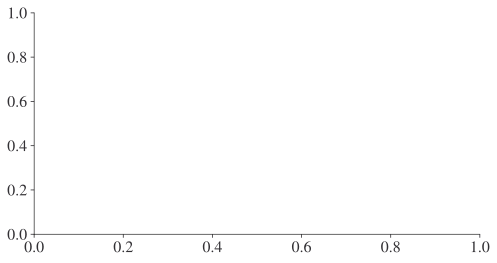

In [10]:
import seaborn as sns

fig, ax = plt.subplots()
sns.barplot(x="country", y="EN.ATM.CO2E.PC", data=df.reset_index(), ax=ax)
ax.set_title(r"CO$_2$ (metric tons per capita)", loc="right")
plt.suptitle("The USA leads the world on per-capita emissions", y=1.01)
for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.yaxis.tick_right()
plt.show()

### The OECD API

Sometimes it's convenient to use APIs directly, and, as an example, the OECD API comes with a LOT of complexity that direct access can take advantage of. The OECD API makes data available in both JSON and XML formats, and we'll use [**pandasdmx**](https://pandasdmx.readthedocs.io/) (aka the Statistical Data and Metadata eXchange (SDMX) package for the Python data ecosystem) to pull down the XML format data and turn it into a regular **pandas** dataframe.

Now, key to using the OECD API is knowledge of its many codes: for countries, times, resources, and series. You can find some broad guidance on what codes the API uses [here](https://data.oecd.org/api/sdmx-ml-documentation/) but to find exactly what you need can be a bit tricky. Two tips are:
1. If you know what you're looking for is in a particular named dataset, eg "QNA" (Quarterly National Accounts), put `https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/QNA/all?format=SDMX-ML` into your browser and look through the XML file; you can pick out the sub-codes and the countries that are available.
2. Browse around on https://stats.oecd.org/ and use Customise then check all the "Use Codes" boxes to see whatever your browsing's code names.

Let's see an example of this in action. We'd like to see the productivity (GDP per hour) data for a range of countries since 2010. We are going to be in the productivity resource (code "PDB_LV") and we want the USD current prices (code "CPC") measure of GDP per employed worker (code "T_GDPEMP) from 2010 onwards (code "startTime=2010"). We'll grab this for some developed countries where productivity measurements might be slightly more comparable. The comments below explain what's happening in each step.

```python
import pandasdmx as pdmx
# Tell pdmx we want OECD data
oecd = pdmx.Request("OECD")
# Set out everything about the request in the format specified by the OECD API
data = oecd.data(
    resource_id="PDB_LV",
    key="GBR+FRA+CAN+ITA+DEU+JPN+USA.T_GDPEMP.CPC/all?startTime=2010",
).to_pandas()

df = pd.DataFrame(data).reset_index()
df.head()
```

```markdown
|   | LOCATION |  SUBJECT | MEASURE | TIME_PERIOD |        value |
|--:|---------:|---------:|--------:|------------:|-------------:|
| 0 |      CAN | T_GDPEMP |     CPC |        2010 | 78848.604088 |
| 1 |      CAN | T_GDPEMP |     CPC |        2011 | 81422.364748 |
| 2 |      CAN | T_GDPEMP |     CPC |        2012 | 82663.028058 |
| 3 |      CAN | T_GDPEMP |     CPC |        2013 | 86368.582158 |
| 4 |      CAN | T_GDPEMP |     CPC |        2014 | 89617.632446 |
```

Great that worked! We have data in a nice tidy format.

### Other Useful APIs

- There is a regularly updated list of APIs over at this [public APIs repo on github](https://github.com/public-apis/public-apis). It doesn't have an economics section (yet), but it has a LOT of other APIs.
- Berkeley Library maintains a [list of economics APIs](https://guides.lib.berkeley.edu/c.php?g=4395&p=7995952) that is well worth looking through.
- [NASDAQ Data Link](https://docs.data.nasdaq.com/), which has a great deal of [financial data](https://docs.data.nasdaq.com/docs/data-organization).
- [DBnomics](https://db.nomics.world/): publicly-available economic data provided by national and international statistical institutions, but also by researchers and private companies.

## Webscraping

Webscraping is a way of grabbing information from the internet that was intended to be displayed in a browser. But it should only be used as a last resort, and only then when permitted by the terms and conditions of a website.

If you're getting data from the internet, it's much better to use an API whenever you can: grabbing information in a structure way is *exactly* why APIs exist. APIs should also be more stable than websites, which may change frequently. Typically, if an organisation is happy for you to grab their data, they will have made an API expressly for that purpose. It's pretty rare that there's a major website which *does* permit webscraping but which doesn't have an API; for these websites, if they don't have an API, chances scraping is against their terms and conditions. Those terms and conditions may be enforceable by law (different rules in different countries here, and you really need legal advice if it's not unambiguous as to whether you can scrape or not.)

There are other reasons why webscraping is not so good; for example, if you need a back-run then it might be offered through an API but not shown on the webpage. (Or it might not be available at all, in which case it's best to get in touch with the organisation or check out WaybackMachine in case they took snapshots).

So this book is pretty down on webscraping as there's almost always a better solution. However, there are times when it is useful.

If you do find yourself in a scraping situation, be really sure to check that's legally allowed and also that you are not violating the website's `robots.txt` rules: this is a special file on almost every website that sets out what's fair play to crawl (conditional on legality) and what robots should not go poking around in.

In Python, you are spoiled for choice when it comes to webscraping. There are five very strong libraries that cover a real range of user styles and needs: **requests**, **lxml**, **beautifulsoup**, **selenium**, and *scrapy**.

For quick and simple webscraping, my usual combo would **requests**, which does little more than go and grab the HTML of a webpage, and **beautifulsoup**, which then helps you to navigate the structure of the page and pull out what you're actually interested in. For dynamic webpages that use javascript rather than just HTML, you'll need **selenium**. To scale up and hit thousands of webpages in an efficient way, you might try **scrapy**, which can work with the other tools and handle multiple sessions, and all other kinds of bells and whistles... it's actually a "web scraping framework".

It's always helpful to see coding in practice, so that's what we'll do now, but note that we'll be skipping over a lot of important detail such as user agents, being 'polite' with your scraping requests, being efficient with caching and crawling.

In lieu of a better example, let's scrape [http://aeturrell.com/](http://aeturrell.com/)

In [12]:
url = "http://aeturrell.com/research"
page = requests.get(url)
page.text[:300]

'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en"><head>\n\n<meta charset="utf-8">\n<meta name="generator" content="quarto-1.5.56">\n\n<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=yes">\n\n<meta name="author" content="Arthur Turrell">\n'

Okay, what just happened? We asked requests to grab the HTML of the webpage and then printed the first 300 characters of the text that it found.

Let's now parse this into something humans can read (or can read more easily) using beautifulsoup:

In [13]:
soup = BeautifulSoup(page.text, "html.parser")
print(soup.prettify()[60000:60500])

       </div>
          <div class="project-category">
           <a href="#category=gender pay gap">
            gender pay gap
           </a>
          </div>
          <div class="project-category">
           <a href="#category=labour">
            labour
           </a>
          </div>
          <div class="project-category">
           <a href="#category=text analysis">
            text analysis
           </a>
          </div>
         </div>
         <div class="project-details-listing


Now we see more structure of the page and even some *HTML tags* such as 'title' and 'link'. Now we come to the data extraction part: say we want to pull out every paragraph of text, we can use beautifulsoup to skim down the HTML structure and pull out only those parts with the paragraph tag ('p').


In [14]:
# Get all paragraphs
all_paras = soup.find_all("p")
# Just show one of the paras
all_paras[1]

<p>Botta, Federico, Robin Lovelace, Laura Gilbert, and Arthur Turrell. "Packaging code and data for reproducible research: A case study of journey time statistics." <i>Environment and Planning B: Urban Analytics and City Science</i> (2024): 23998083241267331. doi: <a href="https://doi.org/10.1177/23998083241267331"><code>10.1177/23998083241267331</code></a></p>

To make this more readable, you can use the `.text` method:

In [15]:
all_paras[1].text

'Botta, Federico, Robin Lovelace, Laura Gilbert, and Arthur Turrell. "Packaging code and data for reproducible research: A case study of journey time statistics." Environment and Planning B: Urban Analytics and City Science (2024): 23998083241267331. doi: 10.1177/23998083241267331'

Now let's say we didn't care about most of the page, we *only* wanted to get hold of the names of projects. For this we need to identify the tag type of the element we're interested in, in this case 'div', and it's class type, in this case "project-name". We do it like this (and show nice text in the process):


In [16]:
projects = soup.find_all("div", class_="project-content listing-pub-info")
projects = [x.text.strip() for x in projects]
projects[:4]

['Botta, Federico, Robin Lovelace, Laura Gilbert, and Arthur Turrell. "Packaging code and data for reproducible research: A case study of journey time statistics." Environment and Planning B: Urban Analytics and City Science (2024): 23998083241267331. doi: 10.1177/23998083241267331',
 'Kalamara, Eleni, Arthur Turrell, Chris Redl, George Kapetanios, and Sujit Kapadia. "Making text count: economic forecasting using newspaper text." Journal of Applied Econometrics 37, no. 5 (2022): 896-919. doi: 10.1002/jae.2907',
 'Turrell, A., Speigner, B., Copple, D., Djumalieva, J. and Thurgood, J., 2021. Is the UK’s productivity puzzle mostly driven by occupational mismatch? An analysis using big data on job vacancies. Labour Economics, 71, p.102013. doi: 10.1016/j.labeco.2021.102013',
 'Haldane, Andrew G., and Arthur E. Turrell. "Drawing on different disciplines: macroeconomic agent-based models." Journal of Evolutionary Economics 29 (2019): 39-66. doi: 10.1007/s00191-018-0557-5']

Hooray! We managed to get the information we wanted: all we needed to know was the right tags. A good tip for finding the tags of the info you want is to look at in your browser (eg Google Chrome) and then right-click on the bit you're interested in, then hit 'Inspect'. This will show you the HTML element of the bit of the page you clicked on.

That's almost it for this very, very brief introduction to webscraping. We'll just see one more thing: how to iterate over multiple pages.

Imagine we had a root webpage such as "www.codingforeconomists.com" which had subpages such as "www.codingforeconomists.com/page=1", "www.codingforeconomists.com/page=2", and so on. One need only iterate create the HTML strings to pass into a function that scrapes each one and return the relevant data, eg for the first 50 pages, and with a function called `scraper()`, one might run

```
start, stop = 0, 50
root_url = "www.codingforeconomists.com/page="
info_on_pages = [scraper(root_url + str(i)) for i in range(start, stop)]
```

That's all we'll cover here but remember we've barely *scraped* the surface of this big, complex topic. If you want to read about an application, it's hard not to recommend the paper on webscraping that has undoubtedly change the world the most, and very likely has affected your own life in numerous ways: ["The PageRank Citation Ranking: Bringing Order to the Web"](http://ilpubs.stanford.edu:8090/422/) by Page, Brin, Motwani and Winograd. For a more in-depth example of webscraping, check out realpython's [tutorial](https://realpython.com/python-web-scraping-practical-introduction/).

### Webscraping Tables

Often there are times when you don't actually want to scrape an entire webpage and all you want is the data from a *table* within the page. Fortunately, there is an easy way to scrape individual tables using the **pandas** package.

We will read data from the first table on 'https://simple.wikipedia.org/wiki/FIFA_World_Cup' using **pandas**. The function we'll use is `read_html()`, which returns a list of dataframes of all the tables it finds when you pass it a URL. If you want to filter the list of tables, use the `match=` keyword argument with text that only appears in the table(s) you're interested in.

The example below shows how this works; looking at the website, we can see that the table we're interested in (of past world cup results), has a 'fourth place' column while other tables on the page do not. Therefore we run:

In [17]:
df_list = pd.read_html(
    "https://simple.wikipedia.org/wiki/FIFA_World_Cup", match="Sweden"
)
# Retrieve first and only entry from list of dataframes
df = df_list[0]
df.head()

,Years,Hosts,Winners,Score,Runner's-up,Third place,Score.1,Fourth place
0,1930 Details,Uruguay,Uruguay,4 - 2,Argentina,United States,[note 1],Yugoslavia
1,1934 Details,Italy,Italy,2 - 1,Czechoslovakia,Germany,3 - 2,Austria
2,1938 Details,France,Italy,4 - 2,Hungary,Brazil,4 - 2,Sweden
3,1950 Details,Brazil,Uruguay,2 - 1,Brazil,Sweden,[note 2],Spain
4,1954 Details,Switzerland,West Germany,3 - 2,Hungary,Austria,3 - 1,Uruguay


This gives us the table neatly loaded into a **pandas** dataframe ready for further use.

## Extracting data from PDFs

PDFs are great. Unfortunately, some people love them so much that they think they're an appropriate way to store data rather than a convenient way to share text and/or figures. Or perhaps there's a table in a PDF that you'd legitimately like to get the info out from.


### Extracting images and text from PDFs

We'll use [**pdftotext**](https://github.com/jalan/pdftotext) to get text out of the same PDF.

In [5]:
import pdftotext
from pathlib import Path

# Download the pdf_with_table.pdf file from
# https://github.com/aeturrell/coding-for-economists/blob/main/data/pdf_with_table.pdf
# and put it in a subfolder called data before running the next line

# Load the PDF
with open(Path("data/pdf_with_table.pdf"), "rb") as f:
    pdf = pdftotext.PDF(f)

# Read all the text into one string; print a chunk of the string
print("\n\n".join(pdf)[:220])

ModuleNotFoundError: No module named 'pdftotext'

Other options for extracting information from PDFs include [**pdfminer**](https://pdfminersix.readthedocs.io) (which can also extract images) and [borb](https://github.com/jorisschellekens/borb) (though be careful of its licence if you're using it for commercial purposes).

### Tables

The single best solution to grab tables is probably [**camelot**](https://camelot-py.readthedocs.io/en/master/index.html). Note that it does need you to have Ghostscript installed on your computer; you can find more information about the dependencies [here](https://camelot-py.readthedocs.io/en/master/user/install.html). It only works with text-based PDFs and not scanned documents: basically, if you can click and drag to select text in your table in a PDF viewer, then your PDF is text-based. In that case, **camelot** is able to sift through the contents and grab any tables and then pass them back as csvs or even **pandas** dataframes.

At the time of writing, **camelot** had some versioning issues related to a dependency on an outdated version of **sqlalchemy**. You may need to install it in a separate virtual environment to use it.

Here's a small example that assumes you have a pdf with a table in stored in a local directory:

```python
import camelot
# Grab the pdf
tables = camelot.read_pdf(os.path.join('data', 'pdf_with_table.pdf'))
```

To extract any of the $n$ tables that are retrieved into a pandas dataframe individually, use `tables[0].df`. 

Note that **camelot** is not perfect--so it can produce a report on how it did when it tried to extract each table, which includes an accuracy score. This is found using, for example, `tables[0].parsing_report`.


### Other useful PDF packages

[**pdfcomments**](https://github.com/hoffmangroup/pdfcomments) is a library that allows you to strip out comments and sticky notes from PDF. This need not strictly be about data extraction, but [**PyPDF2**](https://github.com/py-pdf/pypdf) allows you to both split a PDF into separate pages and merge multiple PDFs together; see [here](http://www.blog.pythonlibrary.org/2018/04/11/splitting-and-merging-pdfs-with-python/) for the steps. (You can drag and drop pages using preview on MacOS but this library may be the easiest way to do the same thing on Windows.)

## Text extraction

Not everything is a PDF file! If you want to get the text out of .doc, .docx, .epub, .gif, .json, .jpg, *.mp3*, .odt, .pptx, .rtf, .xlsx, .xls and, actually, .pdf too, then **textract** is for you. Mostly, it's a wrapper around a ton of other libraries. The upside is that getting the text out should be as easy as calling

```python
import textract
text = textract.process(Path('path/to/file.extension'))
```

The downside is that it requires that some other (non-Python) libraries be installed and it doesn't (yet) work on Windows.

## Review

If you know how to get data from:

- ✅ the internet using a URL;
- ✅ the internet using an API;
- ✅ the internet using webscraping; and
- ✅ PDFs, Microsoft Word Documents, and more, using tools like **pdfminer.six** and **textract**

then you have a good basic set of tools for getting the data that you need into a form you can use.